# Predicción de facturación de consumo energético basado en datos


## Mario José Félix Rojas

## Aprendizaje estadístico 
### Instutito de Física, Universidad de Antioquia, Medellín, Colombia
### 2025

### Introducción

La predicción de la facturación de consumo energético basada en datos se ha convertido en una herramienta esencial para la optimización de recursos y la mejora de la eficiencia en la gestión energética. En un contexto de creciente demanda y preocupación por la sostenibilidad, las empresas y organizaciones buscan modelos que permitan anticipar el comportamiento del consumo energético, previendo fluctuaciones y patrones que podrían afectar el costo de los servicios. Estos modelos se apoyan en técnicas de análisis de datos como el aprendizaje automático y la inteligencia artificial, que permiten analizar grandes volúmenes de información proveniente de facturas, sensores y otros puntos de monitoreo.

### Metodología 



1. Preparación de los Datos
	1.	Extracción de Datos:
	•	Se extrajeron los datos de las facturas en formato PDF y se procesaron para obtener las variables clave necesarias para la predicción:
	•	consumo_kwh_total: Consumo total de energía (kWh).
	•	tasa_seguridad: Tasa de seguridad asociada a la factura.
	•	tarifa_promedio: Tarifa promedio por kWh.
	•	total_factura: Total a pagar de la factura, que será nuestra variable objetivo para la predicción.
	2.	Generación de Datos Sintéticos (Bootstrapping):
	•	Para aumentar el tamaño del conjunto de datos, se utilizó bootstrapping. Esto generó 1000 veces más datos a partir de las observaciones originales, replicando las muestras con reemplazo.
	•	Las variables adicionales se agregaron como dias_facturados, alumbrado_publico, y valor_unitario_kwh, las cuales fueron extraídas del conjunto original de datos.
	3.	Estandarización de los Datos:
	•	Se utilizó StandardScaler para normalizar las características, asegurando que todas las variables tuvieran media 0 y desviación estándar 1.
	4.	División del Conjunto de Datos:
	•	El conjunto de datos se dividió en 80% para entrenamiento y 20% para prueba usando train_test_split de scikit-learn. Se garantizó que los datos se mantuvieran balanceados y representativos de la distribución original mediante estratificación.

⸻

2. Modelos de Red Neuronal (NN)
	1.	Arquitectura de la Red Neuronal:
	•	Se creó un modelo de red neuronal de tipo secuencial con:
	•	2 capas ocultas con 128 y 64 neuronas, utilizando ReLU como función de activación.
	•	Regularización con Dropout (0.2) para evitar el sobreajuste (overfitting).
	•	1 capa de salida con una sola neurona, ya que el objetivo es predecir un valor continuo (el total de la factura).
	2.	Entrenamiento de la Red Neuronal:
	•	Se entrenó el modelo entre 50 y 100 épocas y tamaño de batch de 10.
	•	validation_split=0.2: Utilizamos el 20% de los datos de entrenamiento como validación para monitorear el rendimiento del modelo durante el entrenamiento.

3. Evaluación de los Resultados y Análisis de las Gráficas
	1.	Evaluación del Modelo:
	•	Se utilizó el RMSE y MAE para comparar la precisión de las predicciones sobre el conjunto de prueba. Los resultados de RMSE y MAE fueron calculados para los datos reales y los datos sintéticos (generados por bootstrapping).
	2.	Visualización de la Pérdida durante el Entrenamiento:
	•	Se graficaron las curvas de pérdida de entrenamiento y validación a lo largo de las épocas para ver si el modelo se ajustaba correctamente. Las curvas estabilizadas indican que el modelo estaba aprendiendo bien y no sobreajustado.
	3.	Comparación con Datos Sintéticos:
	•	Se compararon las métricas obtenidas de los modelos entrenados con datos sintéticos y datos reales

### Resultados

In [214]:
import pdfplumber
import re
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
import calendar
import numpy as np

In [102]:
ruta_factura = "./Data/Facturas/Susc1302678-202305.pdf"

#### Código organizado para una factura individual:


In [166]:
import re
from pathlib import Path
from datetime import datetime
import pdfplumber
import pandas as pd

# ---------- Utilidades ----------
def parse_num_colombiano(txt: str):
    if not txt:
        return None
    # Formatos posibles: "23,809,555.00"  o  "23.809.555,00"
    try:
        if txt.count(",") >= 1 and txt.count(".") == 1:
            txt = txt.replace(",", "")
        elif txt.count(".") > 1 and txt.count(",") == 1:
            txt = txt.replace(".", "").replace(",", ".")
        return float(txt)
    except Exception:
        return None

meses = {"enero":1,"febrero":2,"marzo":3,"abril":4,"mayo":5,"junio":6,
         "julio":7,"agosto":8,"septiembre":9,"octubre":10,"noviembre":11,"diciembre":12}

def parse_fecha_expedicion(fecha_str: str):
    # "Mayo 25-2022"
    try:
        partes = fecha_str.strip().split()
        mes = meses[partes[0].lower()]
        dia, anio = partes[1].split("-")
        return datetime(int(anio), mes, int(dia))
    except Exception:
        return None

def numbers_in(line: str):
    return [parse_num_colombiano(x) for x in re.findall(r"[\d.,]+", line) if parse_num_colombiano(x) is not None]

def extract_near_amount(text_lines, anchor, window=6, min_value=1000):
    for i, line in enumerate(text_lines):
        if anchor.lower() in line.lower():
            vals = []
            for j in range(0, window+1):
                if i+j < len(text_lines):
                    vals += numbers_in(text_lines[i+j])
            vals = [v for v in vals if v >= min_value]
            if vals:
                return max(vals)
    return None

def procesar_factura_exhaustiva(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        lines = []
        for page in pdf.pages:
            t = page.extract_text() or ""
            lines += t.split("\n")
        texto = "\n".join(lines)

    # Contrato
    contrato = None
    m = re.search(r"CONTRATO\s+(\d{5,})", texto)
    if m:
        contrato = m.group(1)

    # Fecha expedición
    m = re.search(r"FECHA DE EXPEDICION\s+([A-Za-zÁÉÍÓÚáéíóú]+\s\d{1,2}-\d{4})", texto)
    fecha_expedicion = parse_fecha_expedicion(m.group(1)) if m else None

    # Periodo facturación
    periodo_facturacion = None
    m = re.search(r"Periodo Facturacion\s+([A-Z]{3}\s\d{2}\s+a\s+[A-Z]{3}\s\d{2})", texto, re.IGNORECASE)
    if m:
        periodo_facturacion = m.group(1)

    # Días facturados
    dias_facturados = None
    m = re.search(r"D[ií]as Facturados\s+(\d+)", texto, re.IGNORECASE)
    if m:
        dias_facturados = int(m.group(1))

    # Medidores
    medidores = re.findall(r"No\.?\s*Medidor\s*M\d+\s+([A-Z0-9_]+)", texto)

    # Consumos por "Consumo Actual ... KWH"
    consumos_kwh = []
    for match in re.finditer(r"Consumo\s+Actual\s+([\d\.\s,]{1,20})KWH", texto, re.IGNORECASE):
        consumos_kwh.append(parse_num_colombiano(match.group(1).strip()))
    consumos_kwh = [v for v in consumos_kwh if v is not None]

    # Si no se halló, tomar la "Cantidad" de la línea "Valor Consumo Energía"
    cantidad_kwh = None
    valor_unit_kwh = None
    costo_energia_mes = None
    for i, line in enumerate(lines):
        if "Valor Consumo Energ" in line:
            nums = numbers_in(line)
            # Heurística: Cantidad, Valor Unitario, Valor Total  (tomar 1ro, 2do, 3ro si existen)
            if len(nums) >= 1:
                cantidad_kwh = nums[0]
            if len(nums) >= 2:
                valor_unit_kwh = nums[1]
            if len(nums) >= 3:
                costo_energia_mes = nums[-1]  # último es el total
            # Si no hay suficientes en la misma línea, mirar la siguiente
            if len(nums) < 3 and i+1 < len(lines):
                nums2 = numbers_in(lines[i+1])
                if nums2:
                    if costo_energia_mes is None:
                        costo_energia_mes = max(nums2)
            break

    # Consumo total
    consumo_kwh_total = sum(consumos_kwh) if consumos_kwh else cantidad_kwh

    # Total factura (elegir el mayor "TOTAL A PAGAR")
    totales = re.findall(r"TOTAL A PAGAR\s+\$?\s*([\d.,]+)", texto, re.IGNORECASE)
    totales_vals = [parse_num_colombiano(t) for t in totales if parse_num_colombiano(t) is not None]
    total_factura = max(totales_vals) if totales_vals else None

    # Alumbrado público (buscar cerca de "ALUMBRADO PUBLICO" o "ALUMB.PUB.NO RESIDENCIAL CALI")
    alumbrado_publico = extract_near_amount(lines, "ALUMBRADO PUBLICO", window=6, min_value=1000)
    if alumbrado_publico is None:
        alumbrado_publico = extract_near_amount(lines, "ALUMB.PUB.NO RESIDENCIAL CALI", window=6, min_value=1000)

    # Tasa de seguridad (línea directa)
    m = re.search(r"TASA\s+SEGURIDAD\s+Y\s+CONVIVENCIA\s+([\d.,]+)", texto, re.IGNORECASE)
    tasa_seguridad = parse_num_colombiano(m.group(1)) if m else None
    # Corrección si quedó en cientos
    if tasa_seguridad and tasa_seguridad < 1000:
        tasa_seguridad *= 1000

    # Derivadas
    consumo_promedio_kwh_dia = None
    tarifa_promedio = None
    if consumo_kwh_total and dias_facturados:
        consumo_promedio_kwh_dia = consumo_kwh_total / dias_facturados
    if costo_energia_mes and consumo_kwh_total and consumo_kwh_total != 0:
        tarifa_promedio = costo_energia_mes / consumo_kwh_total

    # Armar DataFrame
    out = pd.DataFrame([{
        "archivo": Path(pdf_path).name,
        "contrato": contrato,
        "fecha_expedicion": fecha_expedicion,
        "periodo_facturacion": periodo_facturacion,
        "dias_facturados": dias_facturados,
        "medidores": medidores or None,
        "consumo_kwh_total": consumo_kwh_total,
        "costo_energia_mes": costo_energia_mes,
        "valor_unitario_kwh": valor_unit_kwh,
        "total_factura": total_factura,
        "alumbrado_publico": alumbrado_publico,
        "tasa_seguridad": tasa_seguridad,
        "consumo_promedio_kwh_dia": consumo_promedio_kwh_dia,
        "tarifa_promedio": tarifa_promedio,
    }])
    return out

df_exhaustivo = procesar_factura_exhaustiva(ruta_fact)
df_exhaustivo.T

,0
archivo,Susc1302678-202305.pdf
contrato,1302678
fecha_expedicion,2023-05-04 00:00:00
periodo_facturacion,MAR 22 a ABR 18
dias_facturados,28
medidores,"[U42A_66621237, Q42A_66621237]"
consumo_kwh_total,30800.0
costo_energia_mes,21634440.52
valor_unitario_kwh,702.42
total_factura,23809555.0


#### Codigo que funciona:

In [164]:
# Código completo de extracción robusta por lote usando el extractor exhaustivo corregido
from pathlib import Path
import pandas as pd
import pdfplumber
import re
from datetime import datetime

# ---------- Utilidades ----------
def parse_num_colombiano(txt: str):
    if not txt:
        return None
    try:
        if txt.count(",") >= 1 and txt.count(".") == 1:
            txt = txt.replace(",", "")
        elif txt.count(".") > 1 and txt.count(",") == 1:
            txt = txt.replace(".", "").replace(",", ".")
        return float(txt)
    except Exception:
        return None

meses = {"enero":1,"febrero":2,"marzo":3,"abril":4,"mayo":5,"junio":6,
         "julio":7,"agosto":8,"septiembre":9,"octubre":10,"noviembre":11,"diciembre":12}

def parse_fecha_expedicion(fecha_str: str):
    try:
        partes = fecha_str.strip().split()
        mes = meses[partes[0].lower()]
        dia, anio = partes[1].split("-")
        return datetime(int(anio), mes, int(dia))
    except Exception:
        return None

def numbers_in(line: str):
    return [parse_num_colombiano(x) for x in re.findall(r"[\d.,]+", line) if parse_num_colombiano(x) is not None]

def extract_near_amount(text_lines, anchor, window=6, min_value=1000):
    for i, line in enumerate(text_lines):
        if anchor.lower() in line.lower():
            vals = []
            for j in range(0, window+1):
                if i+j < len(text_lines):
                    vals += numbers_in(text_lines[i+j])
            vals = [v for v in vals if v >= min_value]
            if vals:
                return max(vals)
    return None

def procesar_factura_exhaustiva(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        lines = []
        for page in pdf.pages:
            t = page.extract_text() or ""
            lines += t.split("\n")
        texto = "\n".join(lines)

    contrato = re.search(r"CONTRATO\s+(\d{5,})", texto)
    contrato = contrato.group(1) if contrato else None

    fexp = re.search(r"FECHA DE EXPEDICION\s+([A-Za-zÁÉÍÓÚáéíóú]+\s\d{1,2}-\d{4})", texto)
    fecha_expedicion = parse_fecha_expedicion(fexp.group(1)) if fexp else None

    m = re.search(r"Periodo Facturacion\s+([A-Z]{3}\s\d{2}\s+a\s+[A-Z]{3}\s\d{2})", texto, re.IGNORECASE)
    periodo_facturacion = m.group(1) if m else None

    m = re.search(r"D[ií]as Facturados\s+(\d+)", texto, re.IGNORECASE)
    dias_facturados = int(m.group(1)) if m else None

    medidores = re.findall(r"No\.?\s*Medidor\s*M\d+\s+([A-Z0-9_]+)", texto)

    consumos_kwh = []
    for match in re.finditer(r"Consumo\s+Actual\s+([\d\.\s,]{1,20})KWH", texto, re.IGNORECASE):
        consumos_kwh.append(parse_num_colombiano(match.group(1).strip()))
    consumos_kwh = [v for v in consumos_kwh if v is not None]

    cantidad_kwh, valor_unit_kwh, costo_energia_mes = None, None, None
    for i, line in enumerate(lines):
        if "Valor Consumo Energ" in line:
            nums = numbers_in(line)
            if len(nums) >= 1: cantidad_kwh = nums[0]
            if len(nums) >= 2: valor_unit_kwh = nums[1]
            if len(nums) >= 3: costo_energia_mes = nums[-1]
            if len(nums) < 3 and i+1 < len(lines):
                nums2 = numbers_in(lines[i+1])
                if nums2 and not costo_energia_mes:
                    costo_energia_mes = max(nums2)
            break

    consumo_kwh_total = sum(consumos_kwh) if consumos_kwh else cantidad_kwh

    totales = re.findall(r"TOTAL A PAGAR\s+\$?\s*([\d.,]+)", texto, re.IGNORECASE)
    totales_vals = [parse_num_colombiano(t) for t in totales if parse_num_colombiano(t) is not None]
    total_factura = max(totales_vals) if totales_vals else None

    alumbrado_publico = extract_near_amount(lines, "ALUMBRADO PUBLICO", window=6, min_value=1000)
    if alumbrado_publico is None:
        alumbrado_publico = extract_near_amount(lines, "ALUMB.PUB.NO RESIDENCIAL CALI", window=6, min_value=1000)

    tasa_seguridad = None
    m = re.search(r"TASA\s+SEGURIDAD\s+Y\s+CONVIVENCIA\s+([\d.,]+)", texto, re.IGNORECASE)
    if m:
        tasa_seguridad = parse_num_colombiano(m.group(1))
        if tasa_seguridad and tasa_seguridad < 1000:
            tasa_seguridad *= 1000

    consumo_promedio_kwh_dia = None
    tarifa_promedio = None
    if consumo_kwh_total and dias_facturados:
        consumo_promedio_kwh_dia = consumo_kwh_total / dias_facturados
    if costo_energia_mes and consumo_kwh_total and consumo_kwh_total != 0:
        tarifa_promedio = costo_energia_mes / consumo_kwh_total

    return pd.DataFrame([{
        "archivo": Path(pdf_path).name,
        "contrato": contrato,
        "fecha_expedicion": fecha_expedicion,
        "periodo_facturacion": periodo_facturacion,
        "dias_facturados": dias_facturados,
        "medidores": medidores or None,
        "consumo_kwh_total": consumo_kwh_total,
        "costo_energia_mes": costo_energia_mes,
        "valor_unitario_kwh": valor_unit_kwh,
        "total_factura": total_factura,
        "alumbrado_publico": alumbrado_publico,
        "tasa_seguridad": tasa_seguridad,
        "consumo_promedio_kwh_dia": consumo_promedio_kwh_dia,
        "tarifa_promedio": tarifa_promedio,
    }])

# Reemplaza "./Data/Facturas" con la ruta real donde tienes tus PDFs
carpeta_facturas = Path("./Data/Facturas")
pdf_paths = sorted(carpeta_facturas.glob("Susc1302678-*.pdf"))

# --- Procesamiento por lote ---
df_lote_exhaustivo = pd.concat([
    procesar_factura_exhaustiva(pdf_path)
    for pdf_path in pdf_paths
], ignore_index=True)


/var/folders/1_/65tnlgjn3mbg11m5sr_t4q900000gn/T/ipykernel_37673/2197108893.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_lote_exhaustivo = pd.concat([


In [165]:
df_lote_exhaustivo

,archivo,contrato,fecha_expedicion,periodo_facturacion,dias_facturados,medidores,consumo_kwh_total,costo_energia_mes,valor_unitario_kwh,total_factura,alumbrado_publico,tasa_seguridad,consumo_promedio_kwh_dia,tarifa_promedio
0,Susc1302678-202201.pdf,1302678,2022-01-08,NOV 19 a DIC 17,29,"[U42A_66621237, Q42A_66621237]",30360.0,16033058.32,528.10,17866616.0,1286449.39,272561.99,1046.896552,528.0981
1,Susc1302678-202202.pdf,1302678,2022-02-15,DIC 18 a ENE 18,32,"[U42A_66621237, Q42A_66621237]",31680.0,17232047.71,543.94,18677501.0,1378706.01,NaN,990.000000,543.9409
2,Susc1302678-202203.pdf,1302678,2022-03-14,ENE 19 a FEB 18,31,"[U42A_66621237, Q42A_66621237]",37840.0,21200204.34,560.26,23323890.0,1697892.85,360403.47,1220.645161,560.2591
3,Susc1302678-202204.pdf,1302678,2022-04-12,FEB 19 a MAR 18,28,"[U42A_66621237, Q42A_66621237]",31680.0,18281482.56,577.07,20120321.0,1462518.60,310785.20,1131.428571,577.0670
4,Susc1302678-202205.pdf,1302678,2022-05-09,MAR 19 a ABR 19,32,"[U42A_66621237, Q42A_66621237]",31680.0,19195555.10,605.92,21124213.0,1535644.41,326324.44,990.000000,605.9203
5,Susc1302678-202206.pdf,1302678,2022-06-07,ABR 20 a MAY 19,30,"[U42A_66621237, Q42A_66621237]",36960.0,22618766.02,611.98,24879532.0,1809501.28,384519.02,1232.000000,611.9796
6,Susc1302678-202207.pdf,1302678,2022-07-06,MAY 20 a JUN 17,29,"[U42A_66621237, Q42A_66621237]",31240.0,20074152.34,642.58,21237639.0,1605932.19,341260.59,1077.241379,642.5785
7,Susc1302678-202208.pdf,1302678,2022-08-04,JUN 18 a JUL 19,32,"[U42A_66621237, Q42A_66621237]",33440.0,22562215.46,674.71,46054842.0,1804977.24,383557.66,1045.000000,674.7074
8,Susc1302678-202209.pdf,1302678,2022-09-06,JUL 20 a AGO 19,31,"[U42A_66621237, Q42A_66621237]",35200.0,24937186.56,708.44,27424502.0,1994974.92,423932.17,1135.483871,708.4428
9,Susc1302678-202210.pdf,1302678,2022-10-07,AGO 20 a SEP 16,28,"[U42A_66621237, Q42A_66621237]",36520.0,26131053.34,715.53,56158177.0,2090484.27,444227.91,1304.285714,715.5272


In [178]:
# HAcemos una copia para trabajar con la copia:

In [180]:
df = df_lote_exhaustivo.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   archivo                   38 non-null     object        
 1   contrato                  38 non-null     object        
 2   fecha_expedicion          38 non-null     datetime64[ns]
 3   periodo_facturacion       38 non-null     object        
 4   dias_facturados           38 non-null     int64         
 5   medidores                 38 non-null     object        
 6   consumo_kwh_total         38 non-null     float64       
 7   costo_energia_mes         38 non-null     float64       
 8   valor_unitario_kwh        38 non-null     float64       
 9   total_factura             38 non-null     float64       
 10  alumbrado_publico         26 non-null     float64       
 11  tasa_seguridad            37 non-null     float64       
 12  consumo_promedio_kwh_dia

In [181]:
df.isna().sum()

archivo                      0
contrato                     0
fecha_expedicion             0
periodo_facturacion          0
dias_facturados              0
medidores                    0
consumo_kwh_total            0
costo_energia_mes            0
valor_unitario_kwh           0
total_factura                0
alumbrado_publico           12
tasa_seguridad               1
consumo_promedio_kwh_dia     0
tarifa_promedio              0
dtype: int64

Hay unos datos que son NaN, por lo que no los voy a eliminar ya que tengo pocos datos, entonces mejor trabajar imputándolos con la media

In [187]:
df["tasa_seguridad"] = df["tasa_seguridad"].fillna(df["tasa_seguridad"].median())
df["alumbrado_publico"] = df["alumbrado_publico"].fillna(df["alumbrado_publico"].median())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   archivo                   38 non-null     object        
 1   contrato                  38 non-null     object        
 2   fecha_expedicion          38 non-null     datetime64[ns]
 3   periodo_facturacion       38 non-null     object        
 4   dias_facturados           38 non-null     int64         
 5   medidores                 38 non-null     object        
 6   consumo_kwh_total         38 non-null     float64       
 7   costo_energia_mes         38 non-null     float64       
 8   valor_unitario_kwh        38 non-null     float64       
 9   total_factura             38 non-null     float64       
 10  alumbrado_publico         38 non-null     float64       
 11  tasa_seguridad            38 non-null     float64       
 12  consumo_promedio_kwh_dia

#### Análisis exploratorio de los datos para la predicción energética:

In [192]:
descripcion = df.describe()

In [193]:
descripcion

,fecha_expedicion,dias_facturados,consumo_kwh_total,costo_energia_mes,valor_unitario_kwh,total_factura,alumbrado_publico,tasa_seguridad,consumo_promedio_kwh_dia,tarifa_promedio
count,38,38.000000,38.000000,3.800000e+01,38.000000,3.800000e+01,3.800000e+01,38.000000,38.000000,38.000000
mean,2023-07-26 00:37:53.684210432,30.815789,34844.921053,2.336983e+07,670.779474,3.571203e+07,1.886793e+06,400227.059211,1132.007252,670.778487
min,2022-01-08 00:00:00,28.000000,28600.000000,1.603306e+07,528.100000,1.786662e+07,1.286449e+06,272561.990000,953.333333,528.098100
25%,2022-10-14 00:00:00,30.000000,32560.000000,2.170405e+07,638.200000,2.508851e+07,1.828418e+06,375278.860000,1053.870968,638.198200
50%,2023-07-21 12:00:00,31.000000,34760.000000,2.375684e+07,693.060000,2.732590e+07,1.920212e+06,404661.590000,1122.024472,693.057750
75%,2024-05-06 06:00:00,31.000000,36960.000000,2.483610e+07,715.432500,4.967310e+07,1.957237e+06,422213.672500,1186.625000,715.430050
max,2025-02-17 00:00:00,42.000000,46200.000000,3.237745e+07,740.070000,8.709580e+07,2.696637e+06,550416.720000,1365.517241,740.065200
std,NaN,2.203870,3467.860968,2.957091e+06,55.448166,1.561645e+07,2.330985e+05,47174.881145,97.785782,55.447576


- La variable fecha_expedicion cubre un periodo de más de 3 años de facturación, con 38 registros mensuales. Con esta variable se puede analizar el consumo en ciertos meses del años o inclusive, si aumenta la tarifa con el año
- La variable dias_facturados, cuya media es de 30.8 días, la mayoría de las facturas cubren ciclos de facturacion de 30 a 31 días, pero hay una factura que cubre 42 días, cuando nos referimos a esa factura y la situación es que facturó un periodo superior a los demás, sin embargo lo hizo para dos meses de NOV 21 a ENE 01, no se podría identificar como un posible outlier.
- La variable consumo_kwh_total, cuya media es de 34,844.9 kWh.
- costo_energia_mes el costo mensual está alineado con el consumo y la tarifa promedia, las variaciones se pueden asociar a cambios regulatorios, fluctuaciones de tarifa o inclusive, subsidios o cargos adicionales.

##### Realizando la visualización de la matriz de correlación como mapa de calor:

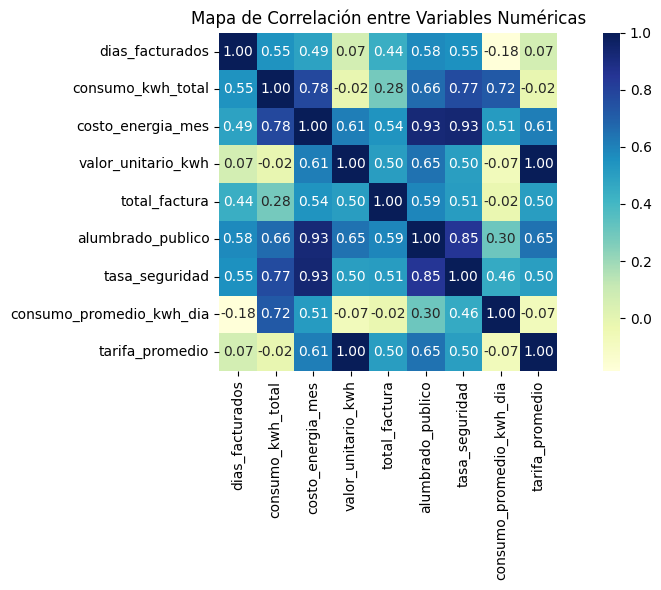

In [196]:
correlaciones = df.select_dtypes(include="number").corr()
# correlaciones
# Visualización: Mapa de calor de correlaciones 
plt.figure(figsize=(10, 6))
sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap="YlGnBu", square=True)
plt.title("Mapa de Correlación entre Variables Numéricas")
plt.tight_layout()
plt.show()

##### Correlaciones fuertes positivas:

* `costo_energia_mes` y `tasa_seguridad`, con un valor de correlación **0.93**:
  La **tasa de seguridad** parece calculada proporcionalmente al **costo de la energía**. Esto sugiere una fórmula dependiente del consumo monetario. Por ejemplo, según lo observado en la factura del **19 de noviembre al 17 de diciembre de 2022**, se cobró un **1.70 %** sobre un consumo total de **\$16'033,058.32**, evidenciando que el cálculo se realiza como un porcentaje del costo base de energía.

* `costo_energia_mes` y `alumbrado_publico`, con valor de correlación también de **0.93**:
  Este comportamiento podría indicar una **fórmula escalada por estratificación** o por bloques tarifarios, ya que el alumbrado se comporta de forma similar al costo energético total.

* `consumo_kwh_total` y `costo_energia_mes`, con un valor de **0.78**:
  Esto es **completamente natural**, ya que más consumo energético (en kWh) se traduce directamente en un mayor costo mensual. Este resultado **valida la coherencia interna del dato**, y descarta errores atípicos severos en estas columnas.

* `consumo_kwh_total` y `consumo_promedio_kwh_dia`, con una correlación de **0.72**:
  Este valor también es esperable, ya que el **consumo total mensual** se construye a partir del consumo diario multiplicado por los días facturados. Este indicador también puede ayudar a validar si hay errores en la derivación de variables calculadas.

* `alumbrado_publico` y `tasa_seguridad`, con una correlación de **0.85**:
  Estas dos tasas probablemente **comparten la misma base de cálculo**. Dado que ambas se calculan con respecto al monto de la factura o al consumo, y pueden ser proporcionales al mismo, su relación es lógica.

* `valor_unitario_kwh` y `tarifa_promedio`, con correlación **1.00**:
  Es una correlación perfecta, lo cual indica que en este dataset **son exactamente iguales o casi iguales**. Esto implica que probablemente provienen de la **misma línea de factura** o se construyen a partir del mismo valor base. Si planeas modelar, puedes optar por **quedarte solo con una de las dos variables**.


##### Correlaciones moderadas (0.4 – 0.7)

* `consumo_kwh_total` y `alumbrado_publico`, con valor de **0.66**:
  Aunque la tasa de alumbrado tiene una fuerte relación con el costo de energía, también guarda una correlación moderada con el consumo total en kWh. Esto podría indicar que **algunas facturas** (o estratos) lo calculan **proporcional al volumen de energía**, aunque en la mayoría se basa en el valor monetario.

* `total_factura` y `alumbrado_publico`, con valor de **0.59**:
  Tiene sentido, ya que el **alumbrado hace parte del total a pagar**, aunque no es la única variable que lo determina. La correlación moderada indica que su impacto es **significativo pero no determinante**.

* `total_factura` y `valor_unitario_kwh`, con valor de **0.50**:
  Esto refleja que **la tarifa por kWh influye directamente en el valor final de la factura**, aunque existen otros componentes como alumbrado, tasa de seguridad y otros cobros que introducen variabilidad.

* `dias_facturados` y `consumo_kwh_total`, con valor de **0.55**:
  Una relación lógica, ya que a más días facturados suele haber mayor consumo, **aunque también depende del uso diario**, lo cual introduce ruido en la correlación.

* `dias_facturados` y `tasa_seguridad`, **0.55**, y también con **`alumbrado_publico`**, **0.58**:
  Esto sugiere que **la duración del período facturado también influye en los cargos asociados**, ya sea porque incrementa el consumo o porque algunas tarifas son **prorrateadas por días**.



##### Correlaciones débiles (0.1 – 0.4)

* `total_factura` y `dias_facturados`, con valor de **0.44**:
  Esta correlación es **esperada pero no fuerte**, ya que el valor total depende más del consumo y la tarifa que de los días facturados. Sin embargo, **más días pueden dar lugar a mayor acumulado de cobros fijos o mínimos**.

* `tarifa_promedio` y `total_factura`, con valor de **0.50**:
  Aunque es moderada, podría haberse esperado más fuerte. Esto sugiere que **la tarifa promedio por kWh no es el único determinante** del valor total. Otras tasas y cargos afectan el monto final.

* `consumo_promedio_kwh_dia` y `costo_energia_mes`, con **0.51**:
  Relación natural: a mayor consumo diario, mayor valor mensual. Sin embargo, **varía en función de los días facturados y la tarifa**, lo cual debilita la relación.


##### Correlaciones negativas (débiles a muy débiles)

* `consumo_promedio_kwh_dia` y `dias_facturados`, con un valor de **-0.18**:
  Este resultado sugiere que en algunos casos, **a menor cantidad de días facturados, el consumo diario promedio puede subir**, probablemente por **picos de consumo** o **cobros mínimos elevados** en períodos cortos.

* `valor_unitario_kwh` y `consumo_kwh_total`, con **-0.02**, y **`tarifa_promedio` y `consumo_kwh_total`**, también con **-0.02**:
  Estas correlaciones tan bajas indican **independencia estadística** entre el volumen de energía consumido y el valor unitario por kWh, lo cual es lógico si **la tarifa por bloque o estrato se mantiene fija**, independientemente del consumo.


#### Gráficos 

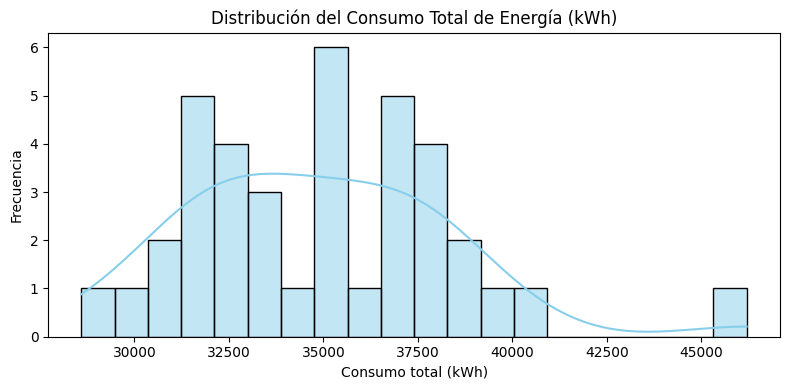

In [199]:
# Gráfico 1: Distribución del consumo total (kWh)
plt.figure(figsize=(8, 4))
sns.histplot(df["consumo_kwh_total"], kde=True, bins=20, color="skyblue")
plt.title("Distribución del Consumo Total de Energía (kWh)")
plt.xlabel("Consumo total (kWh)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

#### Gráfico de distribución del consumo total (kWh)

Este gráfico muestra la **distribución de la variable `consumo_kwh_total`** (consumo de energía en kWh), y tiene dos componentes:

* **El histograma** (barras) muestra **la frecuencia** de los valores en los rangos de consumo de kWh.
* **La curva KDE (Kernel Density Estimate)** muestra una **aproximación suave** de la distribución de la variable.

#### Interpretación de la gráfica:

1. Forma general:
   La **distribución** parece **asimétrica y sesgada** hacia la derecha, lo que indica que **hay más valores bajos de consumo** que altos. Esto es común en datos de consumo energético donde la mayoría de los usuarios tienen consumos moderados, pero algunos tienen consumos extremadamente altos.

2. Moda:
   La mayoría de los valores de consumo se agrupan alrededor de los **35,000 kWh**. Este es el **valor más común** o la **moda** del dataset.

3. Desviación:
   Hay algunas **barras dispersas** que indican que existen **algunos valores atípicos** (outliers) hacia los **valores más altos** de consumo (cerca de 45,000 kWh). Esto podría deberse a **grandes usuarios industriales**, **consumos anómalos** o **errores de medición**.

4. Simetría:
   La distribución muestra que **no es perfectamente normal**. Tiene una ligera **asimetría positiva** (skew), lo que significa que **los valores más altos son menos frecuentes** pero aún significativos.



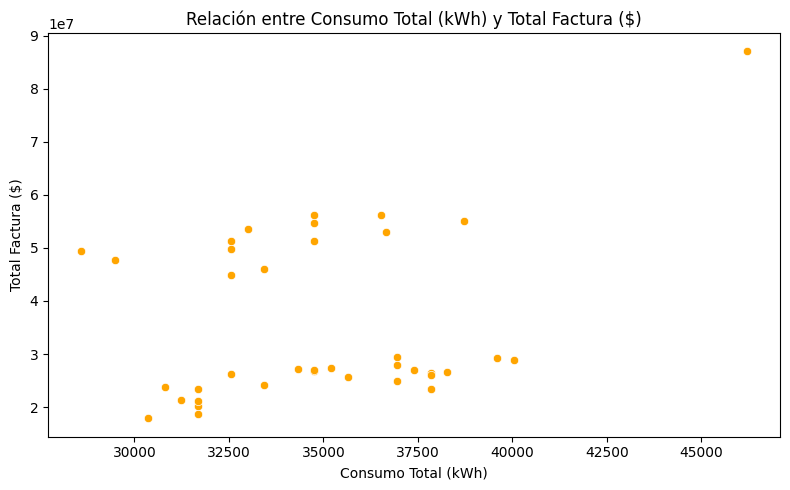

In [198]:
# Gráfico 2: Relación entre consumo total (kWh) y total de la factura
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="consumo_kwh_total", y="total_factura", color="orange")
plt.title("Relación entre Consumo Total (kWh) y Total Factura ($)")
plt.xlabel("Consumo Total (kWh)")
plt.ylabel("Total Factura ($)")
plt.tight_layout()
plt.show()

### Interpretación del gráfico:

1. Relación esperada entre variables:

   * Se espera que **a mayor consumo energético** en kWh, el total de la factura también aumente, y este gráfico muestra justamente eso: hay una **tendencia general positiva**, aunque no es una relación perfectamente lineal.

2. Puntos atípicos (outliers):

   * Hay algunos **puntos alejados** hacia los valores más altos de la factura. Específicamente:

     * En el rango de **45,000 kWh**, hay valores de factura **muy altos** (cerca de 6–8 millones de pesos). Esto podría estar relacionado con **facturación de cargos adicionales**, **subsidios**, **penalizaciones** o **grandes consumidores**.
     * Estos puntos podrían indicar casos **no representativos** del comportamiento general, y podrían ser útiles para analizar de manera separada, dependiendo del contexto.

3. Distribución de los puntos:

   * Los puntos en los **30,000-35,000 kWh** muestran una **dispersión uniforme**, lo que sugiere que la mayoría de las facturas se agrupan en ese rango de consumo.
   * Sin embargo, los **puntos más dispersos** (más lejos de la línea de "mayor consumo" en kWh) indican **facturas con variabilidad**, lo que puede ser consecuencia de otros factores como **tarifas especiales**, **cargos adicionales**, o **grandes consumidores industriales**.


### ¿Qué puedes aprender de este gráfico?

* Consistencia entre consumo y factura: Validamos que la **relación entre `consumo_kwh_total` y `total_factura`** es lógica, aunque no perfecta. Esto puede sugerir que el **costo de la energía y otros cargos adicionales** no siempre son lineales con el consumo.
* Outliers importantes: Los valores fuera de la "zona" del resto de los puntos podrían ser importantes para entender si hay casos de **sobrefacturación**, **recargos excepcionales** o **errores de lectura**.





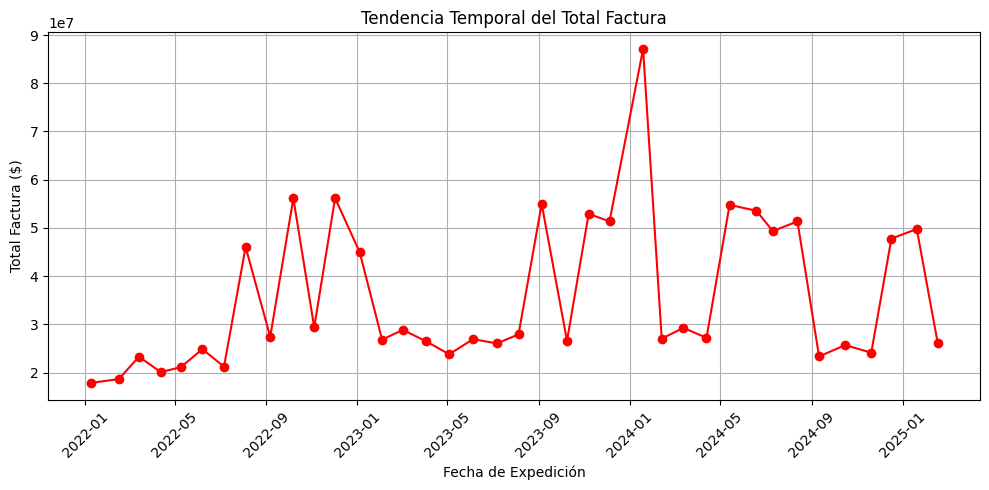

In [202]:
plt.figure(figsize=(10, 5))
df_sorted = df.sort_values("fecha_expedicion")
plt.plot(df_sorted["fecha_expedicion"], df_sorted["total_factura"], marker="o", color="red")
plt.title("Tendencia Temporal del Total Factura")
plt.xlabel("Fecha de Expedición")
plt.ylabel("Total Factura ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

Este gráfico de **evolución temporal** del **total de la factura** nos proporciona una visión clara de cómo varían los valores de la factura a lo largo del tiempo. Se pueden observar las siguientes situaciones:

1. Picos inusuales:

   * Hay **picos marcados** hacia **2024-01**, con facturas de hasta **8 millones de pesos**, que están **fuera de la norma** en el resto de los datos. Este tipo de picos suelen ser **errores de medición, recargos** especiales o **consumos muy altos** en algunos casos. Esos picos podrían reflejar eventos no representativos (como pagos acumulados).

2. Variabilidad en los valores:

   * Aunque no hay una tendencia muy clara en los valores generales de la factura, la **distribución** muestra fluctuaciones que probablemente se deben a **tarifas dinámicas** o **cargos adicionales** que dependen de otras condiciones como el tipo de usuario, temporada del año o **cambio en las tarifas**.

3. Estacionalidad:

   * El gráfico podría estar reflejando **estacionalidades** en el consumo, especialmente hacia principios y mediados de cada año. **Recomendación**: Considerar **modelos de predicción de series temporales** como ARIMA o Prophet si deseas predecir el valor de las facturas en función del tiempo.

4. Tendencia a la baja:

   * A partir de 2024, parece que el consumo y las facturas tienden a estabilizarse, lo que podría implicar la implementación de **políticas de ahorro de energía**, **ajustes de tarifas**, o una **mejora en la eficiencia** del consumo energético.


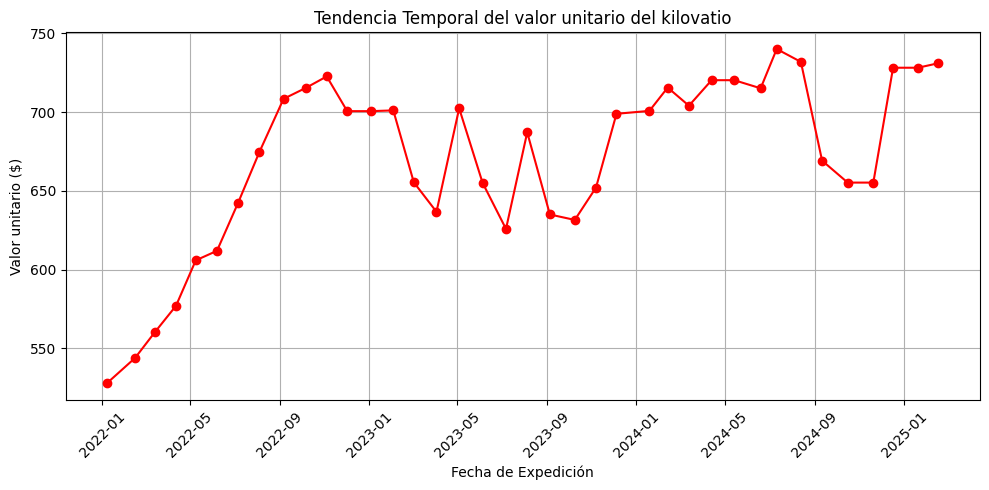

In [205]:
plt.figure(figsize=(10, 5))
df_sorted = df.sort_values("fecha_expedicion")
plt.plot(df_sorted["fecha_expedicion"], df_sorted["valor_unitario_kwh"], marker="o", color="red")
plt.title("Tendencia Temporal del valor unitario del kilovatio")
plt.xlabel("Fecha de Expedición")
plt.ylabel("Valor unitario ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

Este gráfico muestra la evolución temporal del valor unitario del kilovatio (es decir, el costo por cada kWh a lo largo del tiempo).

1. Picos y valles en el valor unitario:

   * Se observa una fluctuación significativa en el valor unitario, especialmente alrededor de **2023-06** y **2024-01**.
   * Este tipo de comportamiento sugiere que las **tarifas energéticas** no son estables, lo que podría deberse a **ajustes de precios** en función de políticas regulatorias, demandas de mercado o **cambios en el costo de generación de energía**.

2. Tendencia creciente hacia finales de 2024 y principios de 2025:

   * Hacia **2024**, hay un **incremento claro** en el valor unitario, lo que podría indicar **ajustes por inflación** o una **nueva estructura tarifaria** implementada por el proveedor de energía.
   * Este comportamiento **afectará directamente las predicciones** del total de la factura, ya que el valor por kWh es un factor clave para su cálculo.

3. Picos a mitad de 2023:

   * Los valores más altos de la serie se encuentran **alrededor de 2023-06 y 2023-12**, lo que sugiere que **puede haber variabilidad estacional** o ajustes tarifarios excepcionales en esos momentos. Esto puede coincidir con **reajustes de tarifas** en ciertos periodos.


* Modelo predictivo: Este gráfico muestra que el **valor unitario** sigue fluctuaciones que podrían predecirse con un modelo de **series temporales**.



## Análisis de Outliers:

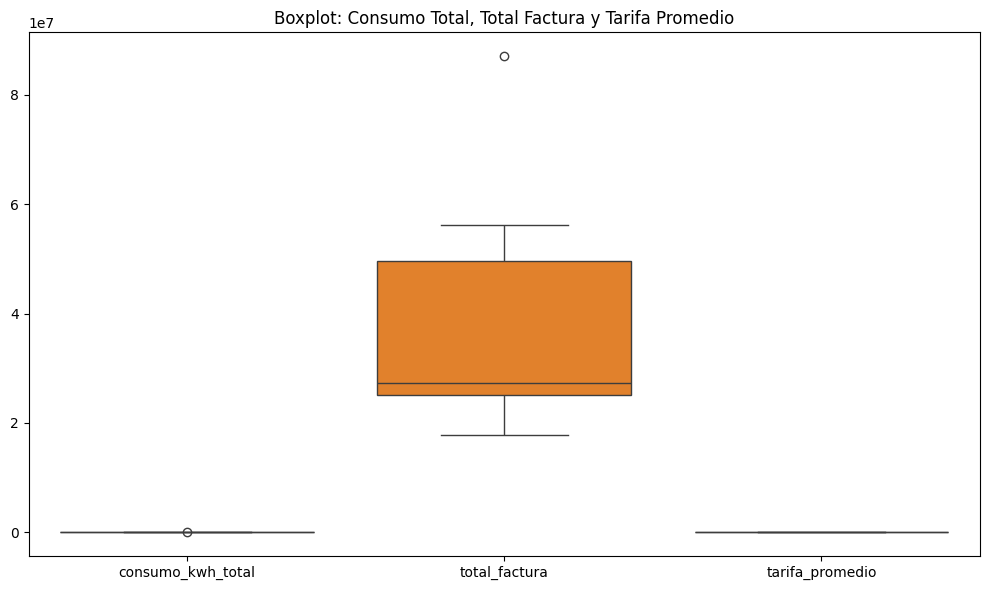

Número de outliers por variable:
 consumo_kwh_total    1
total_factura        1
tarifa_promedio      0
dtype: int64


In [217]:
# 1. Boxplot para visualizar los outliers en las variables clave
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[["consumo_kwh_total", "total_factura", "tarifa_promedio"]])
plt.title("Boxplot: Consumo Total, Total Factura y Tarifa Promedio")
plt.tight_layout()
plt.show()

# 2. Usando el método IQR para detectar outliers en consumo, factura y tarifa
Q1 = df[["consumo_kwh_total", "total_factura", "tarifa_promedio"]].quantile(0.25)
Q3 = df[["consumo_kwh_total", "total_factura", "tarifa_promedio"]].quantile(0.75)
IQR = Q3 - Q1

# Filtrar outliers (valores fuera de [Q1 - 1.5*IQR, Q3 + 1.5*IQR])
outliers = ((df[["consumo_kwh_total", "total_factura", "tarifa_promedio"]] < (Q1 - 1.5 * IQR)) | 
            (df[["consumo_kwh_total", "total_factura", "tarifa_promedio"]] > (Q3 + 1.5 * IQR)))

outliers_count = outliers.sum()
print("Número de outliers por variable:\n", outliers_count)

# 3. Ver qué filas tienen outliers en alguna de las variables
outliers_rows = df[outliers.any(axis=1)]

El outlier de total_factura está relacionado con un periodo de facturación más largo, estos sugiere que el consumo y la facturación están ajustado a un periodo más largo de lo habitual, lo que podría ser válido dependiendo de la naturaleza del servicio. Es un caso excepcional, dado que representa una realidad en el ciclo de facturación, sin embargo, como no es algo habitual con respecto a los demás datos voy a dejarlo fuera del análisis para evitar distorsionar la predicción.

In [219]:
df_clean = df[df["total_factura"] != df["total_factura"].max()]

## Análisis predictivo con redes neuronales

Dado que se busca un modelo de regresión, para esta parte se planteó de la siguiente manera: 

1. Modelo de regresión con el fin de predecir un valor contínuo haciendo uso de los datos reales (38 registros)
2. Modelo de regresión haciendo uso de la generación de datos sintéticos para ampliar el conjunto y mejorar la predicción.

In [235]:
# Importar librerías necesarias
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### 1. Haciendo uso de los datos reales y la generación de los datos sintéticos


Objetivo: Entrenar un modelo predictivo usando los datos reales para predecir el valor total de la factura, basado en otras variables como el consumo del kilovatio total, tasa de seguridad, tarifa promedio, etc.

Metodología a implementar:

1. Preparación de los datos, limpiar los datos de valores faltantes o atípicos (outliers).Seleccionar características relevantes (features) que puedan tener alta correlación con total_factura, como consumo_kwh_total, tasa_seguridad, etc.

2. División de los datos: Dividir los datos en conjunto de entrenamiento y prueba (usualmente 80%-20%).


Para la generación de los datos sintéticos haré uso de bootstrapping.

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - loss: 1349164789137408.0000 - val_loss: 1328446537990144.0000
Epoch 2/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - loss: 1267808847527936.0000 - val_loss: 1190187782635520.0000
Epoch 3/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - loss: 1075468333744128.0000 - val_loss: 946919358595072.0000
Epoch 4/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - loss: 803608715067392.0000 - val_loss: 654753470087168.0000
Epoch 5/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - loss: 525070187364352.0000 - val_loss: 404253361307648.0000
Epoch 6/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - loss: 329641726312448.0000 - val_loss: 264207027142656.0000
Epoch 7/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - loss: 232390463062016.0000 - val_loss: 198286006812672.0000
Epoch 8/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - loss: 185807465873408.0000 - val_loss: 164702248239104.0000
Epoch 9/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - loss

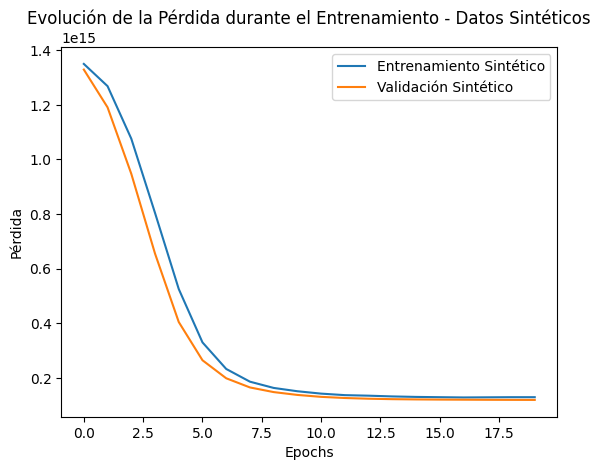

In [242]:
# 1. Generación de datos sintéticos (bootstrapping)
df_bootstrap = df_clean.sample(n=len(df_clean) * 1000, replace=True, random_state=42)  # Aumentamos el tamaño de los datos

# Preparación de los datos
X_synthetic = df_bootstrap[["consumo_kwh_total", "tasa_seguridad", "tarifa_promedio"]]
y_synthetic = df_bootstrap["total_factura"]

# Estandarización de los datos
scaler = StandardScaler()
X_synthetic_scaled = scaler.fit_transform(X_synthetic)

# 2. Dividir el dataset en entrenamiento y prueba (80/20)
X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = train_test_split(X_synthetic_scaled, y_synthetic, test_size=0.2, random_state=42)

# 3. Crear la red neuronal
model_synthetic = Sequential()
model_synthetic.add(Dense(128, input_dim=3, activation='relu'))  # Capa oculta con 128 neuronas
model_synthetic.add(Dropout(0.2))  # Regularización con Dropout
model_synthetic.add(Dense(64, activation='relu'))  # Capa oculta con 64 neuronas
model_synthetic.add(Dropout(0.2))  # Regularización con Dropout
model_synthetic.add(Dense(1))  # Capa de salida (una neurona para la predicción continua)
model_synthetic.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 4. Entrenar la red neuronal con los datos sintéticos (bootstrapping)
history_synthetic = model_synthetic.fit(X_train_synthetic, y_train_synthetic, epochs=20, batch_size=10, validation_split=0.2, verbose=1)

# 5. Evaluar el modelo
loss_synthetic = model_synthetic.evaluate(X_test_synthetic, y_test_synthetic)
y_pred_synthetic = model_synthetic.predict(X_test_synthetic)

# 6. Calcular RMSE y MAE para los datos sintéticos
rmse_synthetic = np.sqrt(mean_squared_error(y_test_synthetic, y_pred_synthetic))
mae_synthetic = mean_absolute_error(y_test_synthetic, y_pred_synthetic)

# Resultados
print(f"Loss on Synthetic Test Set: {loss_synthetic}")
print(f"RMSE (Synthetic Data): {rmse_synthetic}")
print(f"MAE (Synthetic Data): {mae_synthetic}")

# 7. Gráfica de la evolución de la pérdida durante el entrenamiento
import matplotlib.pyplot as plt
plt.plot(history_synthetic.history['loss'], label='Entrenamiento Sintético')
plt.plot(history_synthetic.history['val_loss'], label='Validación Sintético')
plt.title('Evolución de la Pérdida durante el Entrenamiento - Datos Sintéticos')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Añadiendo las demás variables:

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 2s 588us/step - loss: 1346143548080128.0000 - val_loss: 1317183523127296.0000
Epoch 2/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - loss: 1236322308063232.0000 - val_loss: 1133315570532352.0000
Epoch 3/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - loss: 989479397490688.0000 - val_loss: 834736020783104.0000
Epoch 4/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - loss: 681510378143744.0000 - val_loss: 538541117407232.0000
Epoch 5/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - loss: 445152220938240.0000 - val_loss: 367875390963712.0000
Epoch 6/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - loss: 332040130002944.0000 - val_loss: 290039913250816.0000
Epoch 7/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 2s 639us/step - loss: 268133768101888.0000 - val_loss: 233717289189376.0000
Epoch 8/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step - loss: 218946712109056.0000 - val_loss: 190002977832960.0000
Epoch 9/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - loss:

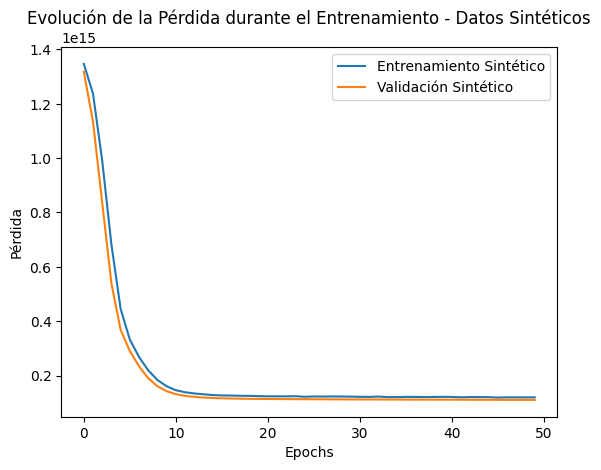

In [ ]:
# Generación de datos sintéticos (bootstrapping)
df_bootstrap = df_clean.sample(n=len(df_clean) * 1000, replace=True, random_state=42)  # Aumentamos el tamaño de los datos


# Preparación de los datos
X_synthetic = df_bootstrap[["consumo_kwh_total", "tasa_seguridad", "tarifa_promedio", 
                            "dias_facturados", "alumbrado_publico", "valor_unitario_kwh"]]
y_synthetic = df_bootstrap["total_factura"]

# Estandarización de los datos
scaler = StandardScaler()
X_synthetic_scaled = scaler.fit_transform(X_synthetic)

# Dividir el dataset en entrenamiento y prueba (80/20)
X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = train_test_split(X_synthetic_scaled, y_synthetic, test_size=0.2, random_state=42)

# Crear la red neuronal
model_synthetic = Sequential()
model_synthetic.add(Dense(128, input_dim=6, activation='relu'))  # Capa oculta con 128 neuronas
model_synthetic.add(Dropout(0.2))  # Regularización con Dropout
model_synthetic.add(Dense(64, activation='relu'))  # Capa oculta con 64 neuronas
model_synthetic.add(Dropout(0.2))  # Regularización con Dropout
model_synthetic.add(Dense(1))  # Capa de salida (una neurona para la predicción continua)
model_synthetic.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

#Entrenar la red neuronal con los datos sintéticos (bootstrapping)
history_synthetic = model_synthetic.fit(X_train_synthetic, y_train_synthetic, epochs=50, batch_size=10, validation_split=0.2, verbose=1)

# Evaluar el modelo
loss_synthetic = model_synthetic.evaluate(X_test_synthetic, y_test_synthetic)
y_pred_synthetic = model_synthetic.predict(X_test_synthetic)

# Calcular RMSE y MAE para los datos sintéticos
rmse_synthetic = np.sqrt(mean_squared_error(y_test_synthetic, y_pred_synthetic))
mae_synthetic = mean_absolute_error(y_test_synthetic, y_pred_synthetic)

# Resultados
print(f"Loss on Synthetic Test Set: {loss_synthetic}")
print(f"RMSE (Synthetic Data): {rmse_synthetic}")
print(f"MAE (Synthetic Data): {mae_synthetic}")

# Gráfica de la evolución de la pérdida durante el entrenamiento
import matplotlib.pyplot as plt
plt.plot(history_synthetic.history['loss'], label='Entrenamiento Sintético')
plt.plot(history_synthetic.history['val_loss'], label='Validación Sintético')
plt.title('Evolución de la Pérdida durante el Entrenamiento - Datos Sintéticos')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


De los resultados anteriores:

El RMSE de 10.35 millones es bastante grande y nos da una idea general de cuánto se desvían nuestras predicciones respecto a los valores reales. En términos de porcentaje de error sobre los valores promedio de facturación (por ejemplo, de 35 millones de pesos), este valor es considerablemente alto (aproximadamente el 30%). El Mean Absolute Error (MAE) es 8.24 millones, lo cual también indica que, en promedio, la predicción se desvía en más de 8 millones de pesos de la realidad.

En la gráfica de la pérdida (de entrenamiento y validación), vemos que tanto la pérdida de entrenamiento como la de validación se estabilizan rápidamente. Esto indica que la red neuronal está aprendiendo de manera eficiente durante las primeras épocas. Sin embargo, si las curvas no bajan tanto o se estabilizan en un valor alto, es posible que la red no haya aprendido suficientemente bien o que la información en los datos sea insuficiente.

In [275]:
# HAciendo una predicción:

# Nuevo conjunto de datos para predicción (aquí puedes colocar los valores que deseas predecir)
# Ejemplo: [consumo_kwh_total, tasa_seguridad, tarifa_promedio, dias_facturados, alumbrado_publico, valor_unitario_kwh]
nuevo_dato = np.array([[df_clean["consumo_kwh_total"].mean(), df_clean["tasa_seguridad"].mean(), 600, 28, 250000, 650]])  # Ejemplo de datos a predecir

# Estandarizar el nuevo dato con el scaler ya entrenado
nuevo_dato_scaled = scaler.transform(nuevo_dato)

# Realizar la predicción
prediccion = model_synthetic.predict(nuevo_dato_scaled)
print(f'Valor promedio de consumo total en los datos: {df_clean["total_factura"].mean()}')
# Imprimir la predicción
print(f"Predicción del Total de la Factura: {prediccion[0][0]:.2f}")

Error = abs(df_clean["total_factura"].mean()- prediccion[0][0]) / df_clean["total_factura"].mean()
print(f'Error con respecto al promedio: {Error*100:.2f} %')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Valor promedio de consumo total en los datos: 34323278.0
Predicción del Total de la Factura: 46487392.00
Error con respecto al promedio: 35.44 %


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Conclusiones:

Los valores RMSE y MAE relativamente altos sugieren que, aunque la red neuronal está aprendiendo, no está alcanzando un buen nivel de precisión con los datos sintéticos generados. Esto podría ser porque el modelo tiene dificultades para generalizar debido a la calidad de los datos o la complejidad del modelo (aunque el modelo es relativamente sencillo).

El hecho de que la pérdida de entrenamiento y validación se estabilicen rápidamente también sugiere que la red no está sobreajustada (overfitting). Esto es positivo, pero también indica que no está aprendiendo mucho más y que podría haber un problema con la cantidad de datos o la capacidad del modelo.

El modelo tiene margen de mejora: La red neuronal está aprendiendo, pero los errores son grandes, lo que indica que se podrían mejorar los resultados con un modelo más complejo o ajustando hiperparámetros. Además hace uso solo datos replicados de bootstrapping no es suficiente para aprender patrones representativos en datos más complejos.